# Fast Approximate MST Clustering Algorithm 

### Proposed Algorithm is named PNNG 

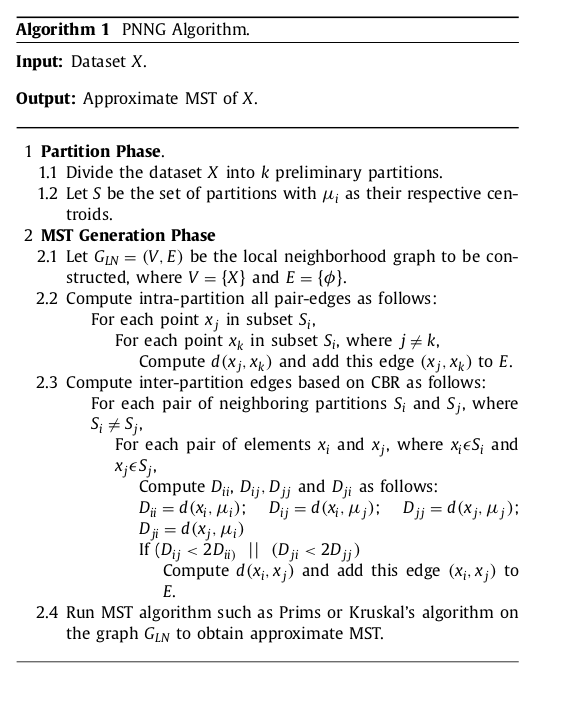

In [536]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
import sklearn
from sklearn import datasets
import matplotlib.lines as mlines
%matplotlib inline

In [537]:
def bimeans(vertices,N):
#     print vertices.shape[0]
    if vertices.shape[0]<=np.sqrt(N):
        return ([vertices])
    centroid=np.mean(vertices,axis=0)
    o=vertices[0]
    for v in vertices:
        if np.sqrt(np.sum((v-centroid)**2))<np.sqrt(np.sum((o-centroid)**2)):
            o=v
    q=vertices[0]
    for v in vertices:
        if np.sqrt(np.sum((v-o)**2))>np.sqrt(np.sum((q-o)**2)):
            q=v
    p=vertices[0]
    for v in vertices:
        if np.sqrt(np.sum((q-v)**2))>np.sqrt(np.sum((q-p)**2)):
            p=v
    lvertices=[]
    rvertices=[]
    for v in vertices:
        if np.sqrt(np.sum((p-v)**2))<=np.sqrt(np.sum((q-v)**2)):
            lvertices.append(v)
        else:
            rvertices.append(v)
    return (bimeans(np.array(lvertices),N)+bimeans(np.array(rvertices),N))


In [538]:
def kmeans(vertices,N):
    clusters=int(np.sqrt(N))
    centroids=np.random.rand(clusters)
    partitions=[np.zeros((0,vertices.shape[1])) for i in xrange(clusters)]
    for it in xrange(200):
        for i in xrange(len(partitions)):
            partitions[i]=np.zeros((0,vertices.shape[1]))
        for v in vertices:
                dist,best=np.inf,0
                for i in xrange(clusters):
                    curr=np.sqrt(np.sum(centroids[i]-v)**2)
                    if curr<dist:
                        dist,best=curr,i
                partitions[best]=np.concatenate((partitions[best],np.reshape(v,(1,v.shape[0]))),axis=0)
        centroids=np.array(map(lambda x:np.mean(x,axis=0),partitions))
    return partitions
    

In [539]:
# Will return adjacency list
def create_edges(vertices):
    N=vertices.shape[0]
    adj_list=[]
    for i in xrange(N):
        adj_list.append(list())
        for j in xrange(N):
            if i==j:
                continue
            adj_list[i].append((j,np.sqrt(np.sum((vertices[j]-vertices[i])**2))))
    return adj_list

In [540]:
#Minimum Spanning Tree (Prims Algorithm) | O(n^2) for Dense Graphs
# Will return tadj_list for the MST
def prims_mst(adj_list):   # AdjList[i]=list((v,cost))
    N=len(adj_list)
    edges=[]
    tadj_list=[[] for i in xrange(N)]
    mark=np.zeros((N+1))
    incoming=np.full((N+1,2),(N,np.inf))
    incoming[0]=(N,0)
    count=0
    while count<N:
        best_vertex=N
        for i in xrange(N):
            if (not mark[i])  and incoming[i][1]<=incoming[best_vertex][1]:
                best_vertex=i
        mark[best_vertex]=1
        if incoming[best_vertex][1]==np.inf:
            incoming[best_vertex][1]=0

        if incoming[best_vertex][0]!=N:
            tadj_list[int(incoming[best_vertex][0])].append((best_vertex,incoming[best_vertex][1]))
        count+=1
        
        for ed in adj_list[best_vertex]:
            if (not mark[ed[0]]) and ed[1]<incoming[ed[0]][1]:
                incoming[ed[0]]=(best_vertex,ed[1])
    return tadj_list

In [541]:
partition_func={'Bi-means':bimeans,'K-means':kmeans}

In [542]:
# Returns the pruned nearest neighbour graph 
# Return Vertices Set, Adjaceny List of NNG 

def pnng(dataset,partition_type='Bi-means'):
    
    X=dataset  
    partitions=partition_func[partition_type](X,X.shape[0])
    centroids=np.array(map(lambda p:np.mean(p,axis=0,dtype=np.float64),partitions))
    centroids_adj_list=create_edges(centroids)
    centroid_mst_adj_list=prims_mst(centroids_adj_list)
    heaviest_edge=0
    
    for i in centroid_mst_adj_list:
        for j in i:
            heaviest_edge=max(heaviest_edge,j[1])
    
    X=partitions[0]
    for i in xrange(1,len(partitions)):
        X=np.concatenate((X,partitions[i]),axis=0)
        
    N=X.shape[0]
    NNG_adj_list=[]
    
    cummulative_index=[]
    pre=0
    for P in partitions:
        cummulative_index.append(pre)
        P_adj_list=create_edges(P)
        NNG_adj_list=NNG_adj_list+P_adj_list
        pre+=P.shape[0]
    
    for i in xrange(len(partitions)):
        for j in xrange(len(partitions)):
            if i==j or np.sqrt(np.sum((centroids[i]-centroids[j])**2))>heaviest_edge:
                continue
            Pi=partitions[i]
            Pj=partitions[j]
            for a in xrange(Pi.shape[0]):
                for b in xrange(Pj.shape[0]):
                    Dii=np.sqrt(np.sum((Pi[a]-centroids[i])**2))
                    Dij=np.sqrt(np.sum((Pi[a]-centroids[j])**2))
                    Djj=np.sqrt(np.sum((Pj[b]-centroids[j])**2))
                    Dji=np.sqrt(np.sum((Pj[b]-centroids[i])**2))
                    if Dij<2*Dii or Dji<2*Djj:
                        NNG_adj_list[cummulative_index[i]+a].append((cummulative_index[j]+b,np.sqrt(np.sum((Pi[a]-Pj[b])**2))))
                        NNG_adj_list[cummulative_index[j]+b].append((cummulative_index[i]+a,np.sqrt(np.sum((Pi[a]-Pj[b])**2))))
    
    NNG_mst_adj_list=prims_mst(NNG_adj_list)
    return (X,NNG_mst_adj_list)
                    
    

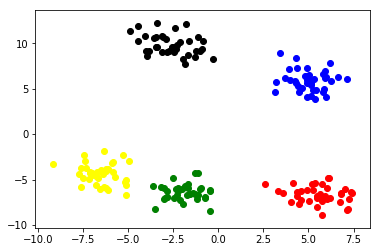

In [543]:
# dataset=sklearn.datasets.make_blobs(200,2,5)
df=pd.read_csv('gaussian.csv')
dataset=df.values
X=dataset[:,:-1]
Y=(dataset[:,-1])
col=['red','blue','green','yellow','black']
plt.figure(0)
for i in xrange(X.shape[0]):
    plt.scatter(X[i:i+1,0],X[i:i+1,1],color=col[int(Y[i])])


In [544]:
np.savetxt("gaussian.csv", np.concatenate((X,Y.reshape((Y.shape[0],1))),axis=1), delimiter=",")


In [545]:
NNG_graph_adj_list=pnng(X)

In [546]:
V,adj_list=NNG_graph_adj_list

In [547]:
def line_plot(x1,y1,x2,y2):
    plt.plot(np.linspace(x1,x2,100),np.linspace(y1,y2,100),c='green',lw=1)

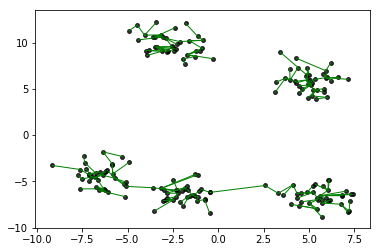

In [555]:
def func(V,adj_lisst):
    for i in xrange(len(V)):
        plt.scatter(V[i][0],V[i][1],color='black',alpha=0.8,s=15)
        for ed in adj_list[i]:
            line_plot(V[i][0],V[i][1],V[ed[0]][0],V[ed[0]][1])
func(V,adj_list)

In [549]:
Vk,adj_list_k=pnng(X,'K-means')

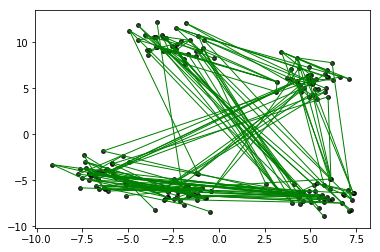

In [556]:
func(Vk,adj_list_k)

In [ ]:
brute_adj_list=create_edges()